In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report

In [46]:
df = pd.read_csv('./data/Modelar_UH2020.txt', index_col='ID', delimiter='|', encoding='utf-8')

In [47]:
df.shape

(103230, 55)

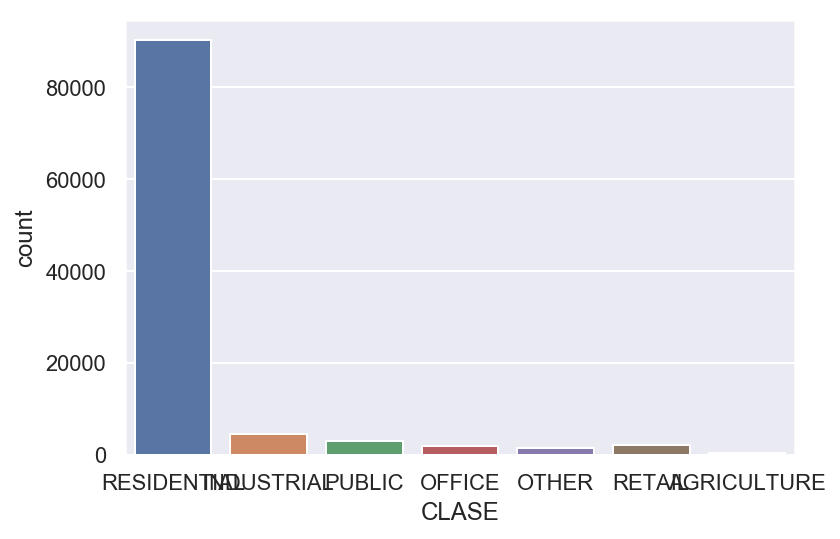

In [48]:
sns.countplot(df.CLASE)

In [49]:
df.CLASE.value_counts()

RESIDENTIAL    90173
INDUSTRIAL      4490
PUBLIC          2976
RETAIL          2093
OFFICE          1828
OTHER           1332
AGRICULTURE      338
Name: CLASE, dtype: int64

In [56]:
df['CADASTRALQUALITYID'].dtype==int

True

In [57]:
def process_cadastral_quality(df):
    dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
    if (df['CADASTRALQUALITYID'].dtype != int):
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)

def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
    
def assing_class(df):
    dic = {'RESIDENTIAL': 0, 'INDUSTRIAL': 1, 'PUBLIC': 2, 'OFFICE': 3, 'RETAIL': 4, 'AGRICULTURE': 5, 'OTHER': 6}
    if (df['CLASE'].dtype != int):
        df['CLASE'] = df['CLASE'].apply(lambda x: dic[x])  
    
def assing_subclass(df):
    df['SUBCLASE'] = (df['CLASE'] == 0).astype(int)

    
    
process_cadastral_quality(df)
process_max_building_floor(df)
assing_class(df)
assing_subclass(df)

In [58]:
X = df.drop(columns='SUBCLASE').copy()
y = df['SUBCLASE'].copy()

sm = SMOTE(random_state=10, sampling_strategy='not majority')
X_res, y_res = sm.fit_resample(X, y)

In [62]:
X_res.CLASE.value_counts()

0    90173
1    32827
2    23746
3    15420
4    10277
5     4831
6     3072
Name: CLASE, dtype: int64

In [74]:
print(f"Hay {np.round((len(y_res[y_res==0]))/len(y_res), 3)} de la clase No Residencial")
print(f"Hay {np.round(1-(len(y_res[y_res==0]))/len(y_res), 3)} de la clase Residencial")

Hay 0.5 de la clase No Residencial
Hay 0.5 de la clase Residencial


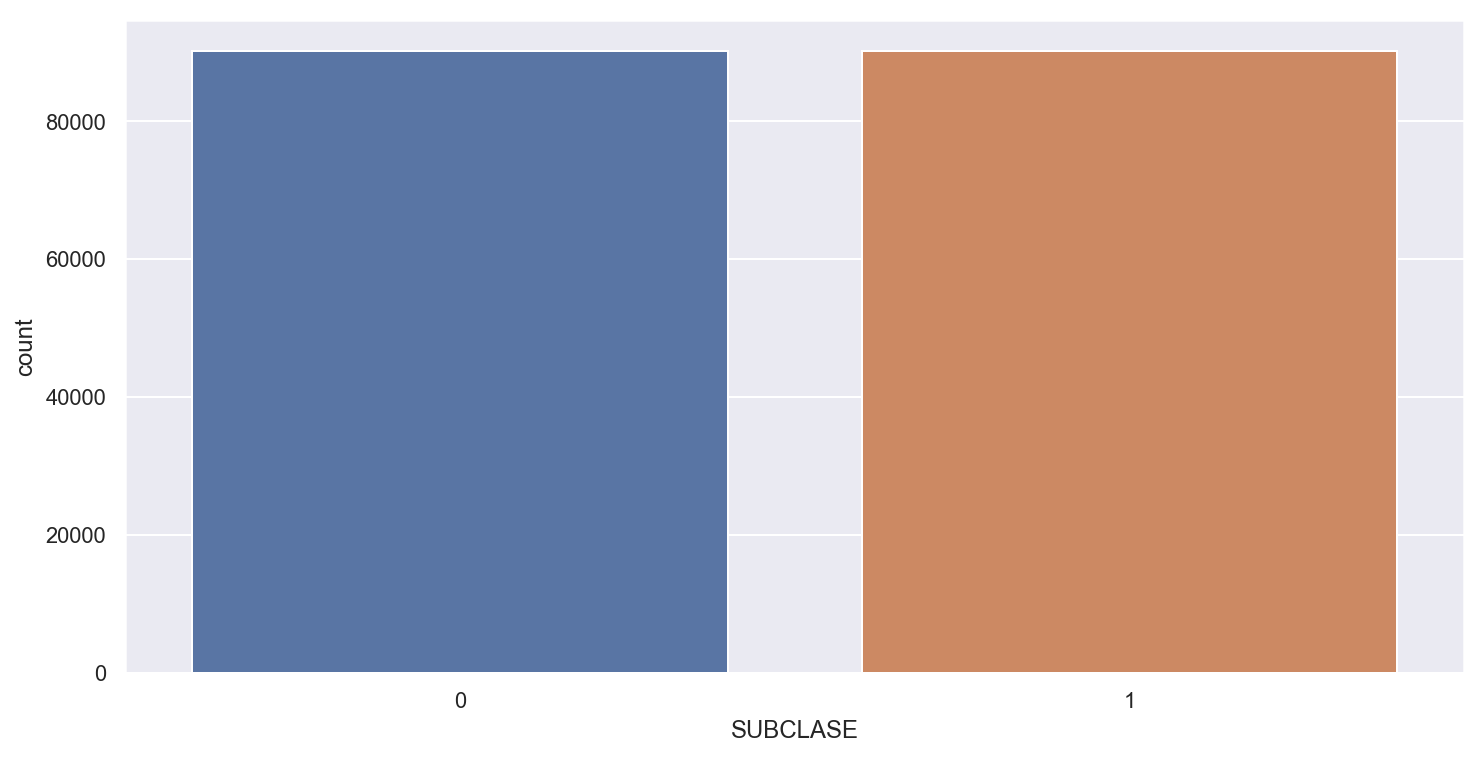

In [71]:
plt.figure(figsize=(12,6))
sns.countplot(y_res)

In [63]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

0.8649762123917358


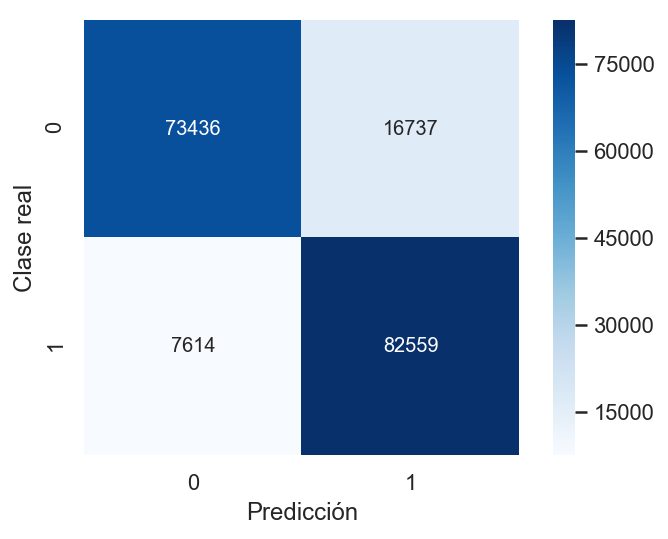

Resultados
Accuracy: 0.865


In [67]:
import pickle
#Cargamos el modelo y predecimos
model_bin = pickle.load(open('./models/binary_14_03.pkl', 'rb'))
result = model_bin.score(X_res, y_res)
print(result)
y_pred = model_bin.predict(X_res)
show_results(y_res, y_pred)

In [69]:
print(classification_report(y_res, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     90173
           1       0.83      0.92      0.87     90173

    accuracy                           0.86    180346
   macro avg       0.87      0.86      0.86    180346
weighted avg       0.87      0.86      0.86    180346



In [89]:
list_ids_no_residential = X_res[y_pred==0].index.tolist()
y_resident = pd.Series(index=X_res[y_pred==1].index, data='RESIDENTIAL')
df_no_resident = X_res[X_res.index.isin(list_ids_no_residential)]

#Modelo final
X_val = df_no_resident.drop(columns='CLASE').copy()
y_val = df_no_resident['CLASE'].copy()

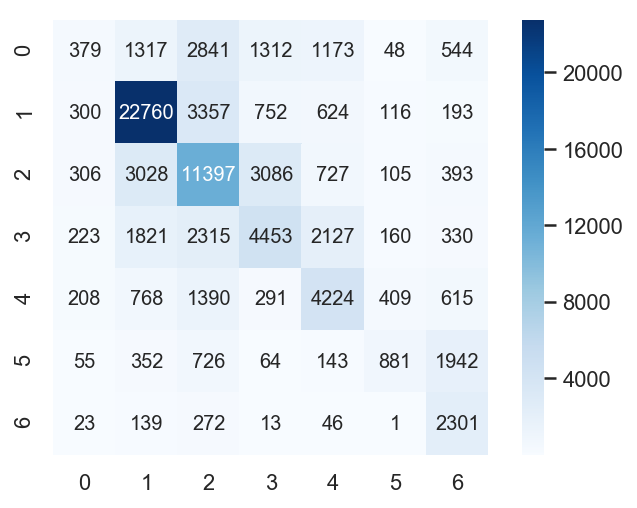

Resultados
Accuracy: 0.572


In [101]:
model_multi = pickle.load(open('./models/multiclass_14_03.pkl', 'rb'))
y_val_pred = model_multi.predict(X_val)
dic = {'RESIDENTIAL': 0, 'INDUSTRIAL': 1, 'PUBLIC': 2, 'OFFICE': 3, 'RETAIL': 4, 'AGRICULTURE': 5, 'OTHER': 6}
y_val_pred_transf = [dic[x] for x in y_val_pred]
sns.heatmap(confusion_matrix(y_val, y_val_pred_transf), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.show()
print("Resultados")
print('Accuracy: {}'.format(round(accuracy_score(y_val, y_val_pred_transf), 3)))

In [103]:
print(classification_report(y_val, y_val_pred_transf))

              precision    recall  f1-score   support

           0       0.25      0.05      0.08      7614
           1       0.75      0.81      0.78     28102
           2       0.51      0.60      0.55     19042
           3       0.45      0.39      0.42     11429
           4       0.47      0.53      0.50      7905
           5       0.51      0.21      0.30      4163
           6       0.36      0.82      0.50      2795

    accuracy                           0.57     81050
   macro avg       0.47      0.49      0.45     81050
weighted avg       0.55      0.57      0.55     81050

